In [1]:
# Cloning and Building Darknet for YOLOv4 on Colab
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 14333, done.
remote: Total 14333 (delta 0), reused 0 (delta 0), pack-reused 14333
Receiving objects: 100% (14333/14333), 12.88 MiB | 25.31 MiB/s, done.
Resolving deltas: 100% (9777/9777), done.


In [2]:
# Verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [3]:
!nvidia-smi

Fri Oct 16 09:53:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

!make

In [ ]:
# Download pre-trained YOLOv4 weights
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights

# Download pre-trained weights for the convolutional layers.
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

In [6]:
# To use Google Drive Files
from google.colab import drive

drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive

Mounted at /content/gdrive


In [7]:
# Upload datasets to Google Drive folder named yolov4 
# Copy over those datasets into the root directory of the Colab VM
!cp /mydrive/yolov4/train.zip ../
!cp /mydrive/yolov4/test.zip ../
!cp /mydrive/yolov4/valid.zip ../

In [ ]:
# Unzip the datasets and their contents so that they are now in /darknet/ folder
!unzip ../train.zip 
!unzip ../test.zip 
!unzip ../valid.zip

In [9]:
# Make a directory named obj in /darknet/data and then copy images and labels
%mkdir data/obj

%cp train/*.jpg data/obj/
%cp valid/*.jpg data/obj/

%cp train/*.txt data/obj/
%cp valid/*.txt data/obj/

In [10]:
# Set up training file directories for custom dataset
!cp /mydrive/yolov4/obj.names  ./data

with open('data/obj.data', 'w') as out:
  out.write('classes = 2\n')
  out.write('train = data/train.txt\n')
  out.write('valid = data/valid.txt\n')
  out.write('names = data/obj.names\n')
  out.write('backup = /mydrive/yolov4/backup/')

In [11]:
import os

# Write train file for the list of images
with open('data/train.txt', 'w') as out:
  for img in [f for f in os.listdir('train') if f.endswith('jpg')]:
    out.write('data/obj/' + img + '\n')

# Write the validation file
with open('data/valid.txt', 'w') as out:
  for img in [f for f in os.listdir('valid') if f.endswith('jpg')]:
    out.write('data/obj/' + img + '\n')

In [12]:
# Write Custom Training Config for YOLOv4

def file_len(fname):
  with open(fname) as f:
    for i, l in enumerate(f):
      pass
  return i + 1

num_classes = file_len('data/obj.names')
max_batches = num_classes*2000
steps1 = int(.8 * max_batches)
steps2 = int(.9 * max_batches)
steps_str = str(steps1)+','+str(steps2)
num_filters = (num_classes + 5) * 3

print("Configuration for the custom YOLOv4 detector")
print("max_batches: " + str(max_batches) + ", but if you are training for 1, 2, or 3 classes it will be 6000.")
print("classes: " + str(num_classes))
print("steps: " + steps_str)
print("filters: " + str(num_filters))

Configuration for the custom YOLOv4 detector
max_batches: 4000, but if you are training for 1, 2, or 3 classes it will be 6000.
classes: 2
steps: 3200,3600
filters: 21


In [13]:
# Copy cfg to Google Drive and change its name
!cp cfg/yolov4-custom.cfg /mydrive/yolov4/yolov4-obj.cfg

In [14]:
# batch = 64 and subdivisions = 16 for ultimate results. 
# If there is any issue then up subdivisions to 32.
# Edit yolov4-obj.cfg accordingly
# Upload the custom .cfg back to cloud VM from Google Drive

!cp /mydrive/yolov4/yolov4-obj.cfg ./cfg

In [15]:
# Train Custom YOLOv4 Detector
# (-dont_show flag stops chart from popping up since Colab Notebook can't open images on the spot, 
# -map flag overlays mean average precision on chart to see how accuracy of our model is, 
# only add map flag if we have a validation dataset)
# (if there is any memory issue then uncomment %%capture below)
# %%capture
!./darknet detector train data/obj.data cfg/yolov4-obj.cfg yolov4.conv.137 -dont_show -map

In [16]:
# Kick off training from where it last saved
# %%capture
!./darknet detector train data/obj.data cfg/yolov4-obj.cfg /mydrive/yolov4/backup/yolov4-obj_last.weights -dont_show -map

In [17]:
# Check if weigths have saved yet
!ls /mydrive/yolov4/backup

yolov4-obj_1000.weights  yolov4-obj_4000.weights  yolov4-obj_last.weights
yolov4-obj_2000.weights  yolov4-obj_5000.weights
yolov4-obj_3000.weights  yolov4-obj_best.weights


In [18]:
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

In [19]:
# Showing chart.png of the custom object detector for the training
imShow('chart.png')

In [20]:
# Checking the Mean Average Precision (mAP) of the custom model
!./darknet detector map data/obj.data cfg/yolov4-obj.cfg /mydrive/yolov4/backup/yolov4-obj_best.weights

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 

In [21]:
# Run the Custom Object Detector!!!
# Need to set the custom cfg for the test mode 
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov4-obj.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov4-obj.cfg
%cd ..

/content/darknet/cfg
/content/darknet


 CUDA-version: 10010 (10010), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x

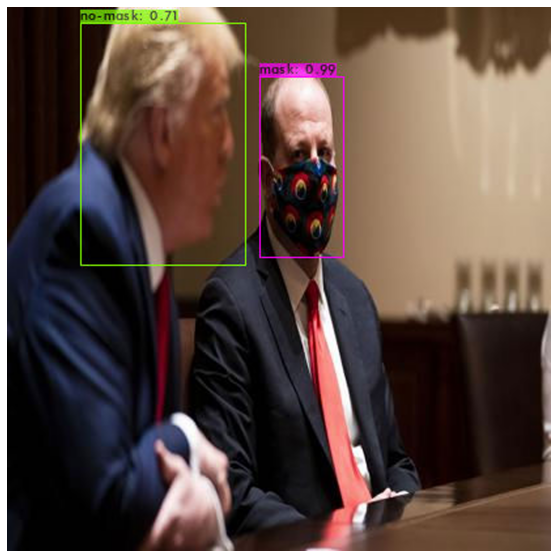

In [22]:
# Use images from /test to test the detector
import os
test_images = [f for f in os.listdir('test') if f.endswith('.jpg')]
import random
img_path = "test/" + random.choice(test_images)

!./darknet detector test data/obj.data cfg/yolov4-obj.cfg /mydrive/yolov4/backup/yolov4-obj_best.weights {img_path} -dont-show -thresh 0.3
imShow('predictions.jpg')